In [8]:
from mongoengine import *
import numpy as np
import datetime 
import pandas
import matplotlib.pyplot as plt
import sklearn
import tabulate

In [9]:
connect("GDP-test", host = "localhost", port = 27017)
class Detection(Document):
    id_webcam = IntField(required=True)
    city = StringField(required=True)
    location = StringField(required=True)
    latitude = FloatField(required=True)
    longitude = FloatField(required=True)
    numPeople = IntField(required=True)
    date = DateTimeField(required=True)
    time = DateTimeField(required=True)
    type = IntField(required=True)
    weather_description = StringField()
    temperature = FloatField()
    day_of_week = IntField()

In [61]:
#print(Detection.objects.distinct('city')) # vedere se posso prendere solo le città per poi fare query distinte
table = pandas.DataFrame(Detection.objects(city='Roma').as_pymongo()) #prelevo i dati di roma

table_a = table
table_a = table_a.drop(columns = ['_id','id_webcam','city','type','day_of_week','temperature','date','location','latitude','longitude','weather_description'])
table_a['time'] = pandas.to_datetime(table_a['time'])
table_a.sort_values(by='time', inplace=True)
table_a = table_a.resample('30T', on='time').numPeople.mean()

print(table_a.to_markdown())

| time                |   numPeople |
|:--------------------|------------:|
| 2021-03-24 09:00:00 |     7       |
| 2021-03-24 09:30:00 |     9.83333 |
| 2021-03-24 10:00:00 |    10.1667  |
| 2021-03-24 10:30:00 |    14.5     |
| 2021-03-24 11:00:00 |    15.1667  |
| 2021-03-24 11:30:00 |    13       |
| 2021-03-24 12:00:00 |    13.5     |
| 2021-03-24 12:30:00 |    11.5     |
| 2021-03-24 13:00:00 |    11       |
| 2021-03-24 13:30:00 |    11.1667  |
| 2021-03-24 14:00:00 |     9.33333 |
| 2021-03-24 14:30:00 |    10       |
| 2021-03-24 15:00:00 |     9.5     |
| 2021-03-24 15:30:00 |    12       |
| 2021-03-24 16:00:00 |    11       |
| 2021-03-24 16:30:00 |    10.5     |
| 2021-03-24 17:00:00 |    12.1667  |
| 2021-03-24 17:30:00 |    14.6667  |
| 2021-03-24 18:00:00 |    12.8333  |
| 2021-03-24 18:30:00 |    11.6667  |
| 2021-03-24 19:00:00 |     9.66667 |
| 2021-03-24 19:30:00 |     7       |
| 2021-03-24 20:00:00 |     6.83333 |
| 2021-03-24 20:30:00 |     6.16667 |
| 2021-03-24

|      |   numPeople | time                       |
|-----:|------------:|:---------------------------|
|   10 |           6 | 2021-03-24 09:01:55.210000 |
|    4 |           6 | 2021-03-24 09:06:55.172000 |
|   18 |           7 | 2021-03-24 09:11:55.164000 |
|   16 |          10 | 2021-03-24 09:16:55.110000 |
|    3 |           6 | 2021-03-24 09:21:55.152000 |
|   20 |           7 | 2021-03-24 09:26:55.174000 |
|    7 |          10 | 2021-03-24 09:31:55.242000 |
|    2 |           9 | 2021-03-24 09:36:55.182000 |
|    5 |           9 | 2021-03-24 09:41:55.123000 |
|    6 |           9 | 2021-03-24 09:46:55.291000 |
|   13 |          11 | 2021-03-24 09:51:55.187000 |
|    8 |          11 | 2021-03-24 09:56:55.118000 |
|    9 |           8 | 2021-03-24 10:01:55.198000 |
|   14 |           6 | 2021-03-24 10:06:55.215000 |
|   11 |           9 | 2021-03-24 10:11:55.169000 |
|   12 |          14 | 2021-03-24 10:16:55.214000 |
|   15 |          13 | 2021-03-24 10:21:55.262000 |
|   28 |    

AttributeError: module 'sklearn' has no attribute 'model_selection'

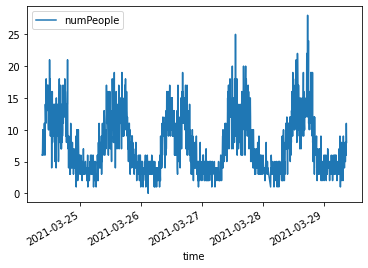

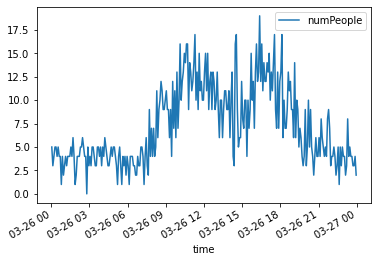

In [36]:
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude']) #tolgo colonne inutili
table.plot('time','numPeople')
table['time'] = table['time'].dt.strftime('%H').astype(int)#modifico le colonne con i valori che mi servono
table['weather_description'] = pandas.get_dummies(table['weather_description']) #il weather viene convertito con parametri interi
#print(table.to_markdown())

start = datetime.datetime(2021,3,26)
end = datetime.datetime(2021,3,27)
raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
table.plot('time','numPeople')

#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    table[['time','temperature','day_of_week','weather_description']], 
    table['numPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)


In [ ]:
model = sklearn.linear_model.LinearRegression()
#provo a dargli in pasto tutto
#prima di questo ora bisogna dividere tutto il dataset in 70-30
model.fit(x_train, y_train)


# The coefficients
print('Coefficients: \n', model.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(x_test, y_test))

plt.plot(x_test['time'],y_test)


In [ ]:

#robe vecchie sbagliate non guardare

time, temperature, weather, numP = table['time'].dt.strftime('%H').astype(int),table['temperature'],table['weather_description'],table['numPeople']
time = np.asarray(time)
temperature = np.asarray(temperature)
weather = np.asarray(weather)
numP = np.asarray(numP)
weatherDict = {'clear sky':0}

In [ ]:
for i in range(weather.size):
    weather[i] = weatherDict[weather[i]]

In [ ]:
temperature = temperature.reshape(-1,1)
time = time.reshape(-1,1)
weather = weather.reshape(-1,1)
timeTemp = np.concatenate((time,temperature,weather),axis = 1)
print(timeTemp)
model = sklearn.linear_model.LinearRegression()
model.fit(timeTemp,numP) 

In [ ]:
start = datetime.datetime(2021,3,24)
end = datetime.datetime(2021,3,29)
raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])